# Population oscillations
### 1. Overview
In this section we are going to explore different models's ability to reproduce the collective oscillation behavior of *Dictyostelium* cells (Figure 6, below). Another important feature has been shown experimentally is that with $cAMP_{e}$ applied, population oscillations get repressed (Figure 8, below).

With this notebook, you can visualize population mean of $cAMP_{i}$ as well as the that of individual cells in models with noise. Additionally, you can alter parameters of each model, set $cAMP_{e}$ influx concentrations, and see how those affects population-wide oscillations.  
![Figure 6](imgs/fig6_pop_oscillation_SCnoise.png)
<h5><center>Figure6</center></h5>

![Figure 8](imgs/fig8_pop_add_cAMP.png)
<h6><center>Figure8</center></h6>

#### Let's start by importing packages and setting up time scaling parameters

In [1]:
import os
import numpy as np
import random
import math
import matplotlib.pyplot as plt
#%% set up plotting font
import matplotlib
font = {'family' : 'Arial'}
matplotlib.rc('font', **font)

%matplotlib inline  
from scipy import signal
from scipy.signal import chirp, find_peaks, peak_widths
import pandas as pd
import scipy.io

os.chdir("../compare_models")
from Goldbeter1987_agent_and_pop_FUN import Goldbeter1987_pop_3var_SCnoise
from MaedaLoomis2004_agent_and_pop_FUN import MaedaLoomis2004_pop_SCnoise
from Kamino2017_agent_and_pop_FUN import Kamino2017_pop_SCnoise
from Sgro2015_agent_and_pop_FUN import Sgro2015_pop
from Gregor2010_agent_and_pop_FUN import Gregor2010_pop

from NB_pop_functions import * 
# Normalization parameters
from NormParam import *
os.chdir(r"../Notebooks") 

### 2. Experimental data 
#### import and plot experimental data

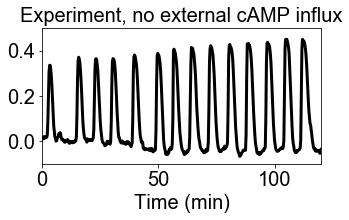

Text(0.7, 0.75, ' High External cAMP, \n 100nM')

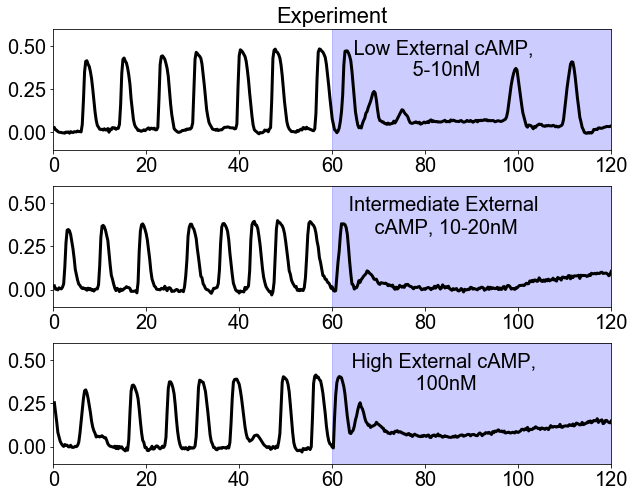

In [2]:
Sgro2015Figure6excel = pd.read_excel(r'../exp_data/Sgro2015DataFormattedforPython.xlsx',sheet_name='Figure6')

fig = plt.figure(figsize=(5, 2.5))
grid = plt.GridSpec(1,1)
ax0= fig.add_subplot(grid[0, 0])
ax0.plot(Sgro2015Figure6excel["Times (min)"],Sgro2015Figure6excel["No External cAMP Mean Trace"],
                              color = 'k',linewidth=3)
ax0.tick_params(axis='both', which='major', labelsize=20)
ax0.set_title('Experiment, no external cAMP influx', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax0.set_ylim([-0.1,0.5]); ax0.set_xlim([0,120])
ax0.set_xlabel('Time (min)', size=20)
plt.show()

fig1 = plt.figure(figsize=(10, 8))
grid = plt.GridSpec(3, 1, wspace=0.5, hspace=0.3)

ax02= fig1.add_subplot(grid[0, 0])
ax02.plot(Sgro2015Figure6excel["Times (min)"],Sgro2015Figure6excel["Low External cAMP Mean Trace"],
                               color = 'k', linewidth=3)
ax02.axvspan(60, 120, alpha=0.2, color='b')
ax02.set_ylim([-0.1,0.6]);ax02.set_xlim([0,120])
ax02.tick_params(grid_linewidth = 15, labelsize = 20)
ax02.text(0.7,0.75,' Low External cAMP, \n 5-10nM', ha='center',va='center',
         transform = ax02.transAxes, color = 'k', fontsize=20)
ax02.set_title('Experiment',size=22)
ax03= fig1.add_subplot(grid[1, 0])
ax03.plot(Sgro2015Figure6excel["Times (min)"],Sgro2015Figure6excel["Intermediate External cAMP Mean Trace"],
                               color = 'k', linewidth=3)
ax03.axvspan(60, 120, alpha=0.2, color='b')
ax03.set_ylim([-0.1,0.6]);ax03.set_xlim([0,120])
ax03.tick_params(grid_linewidth = 15, labelsize = 20)
ax03.text(0.7,0.75,' Intermediate External \n cAMP, 10-20nM', ha='center',va='center',
         transform = ax03.transAxes, color = 'k', fontsize=20)

ax04= fig1.add_subplot(grid[2, 0])
ax04.plot(Sgro2015Figure6excel["Times (min)"],Sgro2015Figure6excel["High External cAMP Mean Trace"],
                               color = 'k', linewidth=3)
ax04.axvspan(60, 120, alpha=0.2, color='b')
ax04.set_ylim([-0.1,0.6]);ax04.set_xlim([0,120])
ax04.tick_params(grid_linewidth = 15, labelsize = 20)
ax04.text(0.7,0.75,' High External cAMP, \n 100nM', ha='center',va='center',
         transform = ax04.transAxes, color = 'k', fontsize=20)

### 3. Matiel 1986
#### Set up parameters (from Table II in [Matiel & Goldbeter 1986](https://www.sciencedirect.com/science/article/pii/S0006349587832757?via%3Dihub) )

In [3]:
k1 = 0.036     # per min
k2 = 0.666    # per min
L1 = 10; L2 = 0.005 
c = 10;           # 0.15 ~ 50
lamda = 0.01; theta = 0.01; e =  1 ; q = 4000; sig= 0.6
v = 12; k = 4 # k prime in the paper
ki = 1.7; kt = 0.9; kc = 5.4; h = 5

sigma = 10 # noise strength
N = 100 # number of cells in the population

Goldbeter3PopParam={'k1':k1,'k2':k2,'L1':L1,'L2':L2, 'c':c, 'lamda':lamda,\
            'theta':theta, 'e':e, 'q':q,'sig':sig, 'v':v, 'k':k, \
            'ki':ki,'kt':kt, 'kc':kc,'h':h,'sigma':sigma, 'N':N}
dt=0.001; t_tot=30; t=list(np.arange(0,t_tot*Nt_Goldbeter,dt))
nSteps = len(t)

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [4]:
# cAMPe influx level. By default low, itermediate and high levels are 0.01, 0.02 and 0.1
cAMPext_influx=0.02

stim_time= 0.5 # cAMPext_influx happens at half the total time
stim_time_step=int(round(stim_time*t_tot*Nt_Goldbeter/dt)) # at this time step input is applied
campExt_influx_trace=np.zeros(len(t))
campExt_influx_trace[stim_time_step:] = cAMPext_influx

# Initializations
p0=0.8*np.ones(N); a0=3; b0=0.9*np.ones(N); g0=0
p_trace=np.zeros((N,nSteps));p_trace[:,0] = p0; 
b_trace=np.zeros((N,nSteps));b_trace[:,0] = b0; 
g_trace=np.zeros((nSteps,1));g_trace[0] = g0; 

Goldbeter3_pop= Goldbeter1987_pop_3var_SCnoise(0,p0,b0,g0,Goldbeter3PopParam)

for i in range(len(t)-1):
    p_next,b_next,g_next= Goldbeter3_pop.update(dt,a0,campExt_influx_trace[i]) # cAMPext_influx_trace[i])
    p_trace[:,i+1]= p_next
    b_trace[:,i+1]= b_next
    g_trace[i+1] = g_next
    
# Rescale time
t_plot_Goldbeter = np.array(t)/(Nt_Goldbeter)
# Normalize height 
b_trace_norm = b_trace/Nh_Goldbeter
# population mean
b_trace_norm_mean = np.mean(b_trace_norm,axis = 0)

#### Plot population $cAMP_i$  trace

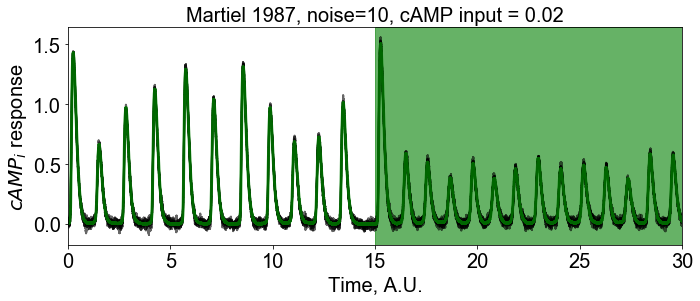

In [5]:
# Plot outputs
# specify which single cell traces to display
SC_traces_idx = [0,1,2,3,4,5]
# plot population mean and individual traces
title = 'Martiel 1987, noise=' +str(sigma)+', cAMP input = '+ str(cAMPext_influx)
plot_POP_oscillation(t_plot_Goldbeter,b_trace_norm_mean,cAMPext_influx, 
                     t_tot, stim_time,title,b_trace_norm, SC_traces_idx)

### 4. Maeda 2004
#### Set up parameters (from supplementary in [Maeda et al 2004](https://science.sciencemag.org/content/304/5672/875/tab-figures-data) )

In [6]:
k1=2.0; k2=0.9; k3=2.5; k4=1.5; k5=0.6
k6=0.8; k7=1.0; k8=1.3; k9=0.3; k10=0.8
k11=0.7; k12=4.9; k13=23; k14=4.5
gamma = 0# [cAMP]e flow rate 
rho = 1 # cell density

sigma = 0.1 # noise strength
N = 100 # number of cells in the population

MaedaPopParam={'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,'k6':k6,\
            'k7':k7,'k8':k8,'k9':k9,'k10':k10,'k11':k11,'k12':k12,\
            'k13':k13,'k14':k14, 'N':N, 'sigma':sigma}

dt=0.0001; t_tot=60; t=list(np.arange(0,t_tot*Nt_Maeda,dt))
nSteps = len(t)

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [7]:
# cAMPe influx level. By default low, itermediate and high levels are 0.005, 0.05 and 0.5
cAMPext_influx=0.05 

stim_time= 0.75 # cAMPext_influx happens at 3/4 of total time
# allow for oscillation stablize for longer before cAMPe is applied
stim_time_step=int(round(stim_time*t_tot*Nt_Maeda/dt)) # at this time step input is applied
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx_trace[stim_time_step:] = cAMPext_influx

ACA0=0.1*np.ones(N); PKA0=0.1*np.ones(N); ERK20=0.1*np.ones(N); 
RegA0=0.1*np.ones(N); cAMPi0=0.01*np.ones(N); cAMPe0=0.1; CAR10=0.1*np.ones(N)

ACA_trace=np.zeros((N,nSteps)); ACA_trace[:,0] = ACA0
PKA_trace=np.zeros((N,nSteps)); PKA_trace[:,0] = PKA0
ERK2_trace=np.zeros((N,nSteps)); ERK2_trace[:,0] = ERK20
RegA_trace= np.zeros((N,nSteps)); RegA_trace[:,0] = RegA0
cAMPi_trace= np.zeros((N,nSteps)); cAMPi_trace[:,0] = cAMPi0
cAMPe_trace=np.zeros((nSteps,1));cAMPe_trace[0] = cAMPe0;
CAR1_trace= np.zeros((N,nSteps)); CAR1_trace[:,0] = CAR10

MaedaLoomis_pop=MaedaLoomis2004_pop_SCnoise([1,1],ACA0,PKA0,ERK20,RegA0,cAMPi0,cAMPe0,CAR10, 
                                            MaedaPopParam)

for i in range(len(t)-1):
    ACA_next,PKA_next,ERK2_next,RegA_next,\
    cAMPi_next,cAMPe_next,CAR1_next=MaedaLoomis_pop.update(dt,cAMPext_influx_trace[i],rho,gamma)
    ACA_trace[:,i+1]= ACA_next
    PKA_trace[:,i+1]= PKA_next
    ERK2_trace[:,i+1]= ERK2_next
    RegA_trace[:,i+1]= RegA_next
    cAMPi_trace[:,i+1]= cAMPi_next
    cAMPe_trace[i+1]= cAMPe_next
    CAR1_trace[:,i+1]= CAR1_next
    
cAMPi_trace_norm = cAMPi_trace/Nh_Maeda   
cAMPi_trace_norm_mean = np.mean(cAMPi_trace_norm,axis = 0) # population mean

later_portion = 0.5 # start count peaks after this X total simulation time
cAMPi_trace_norm_later = cAMPi_trace_norm[:,math.floor(nSteps * later_portion):]
cAMPi_trace_norm_mean_later=cAMPi_trace_norm_mean[math.floor(nSteps * later_portion):] # the later part of trace

t_plot_Maeda = np.array(t)/Nt_Maeda
t_plot_Maeda_short = t_plot_Maeda[0:math.floor(nSteps * (1-later_portion))] 

#### Plot population $cAMP_i$  trace

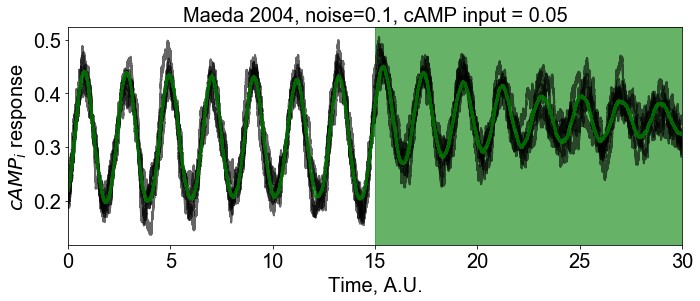

In [8]:
# Plot outputs
# specify which single cell traces to display
SC_traces_idx = [0,1,2,3,4,5]
# plot population mean and individual traces
title = 'Maeda 2004, noise=' +str(sigma)+', cAMP input = '+ str(cAMPext_influx)
plot_POP_oscillation(t_plot_Maeda_short,cAMPi_trace_norm_mean_later,cAMPext_influx, 
                     t_tot*(1-later_portion), 0.5,title,cAMPi_trace_norm_later, SC_traces_idx)

#

### 5. Gregor 2010 
#### Set up parameters

In [9]:
Amax=20;  Abas=0.4 # uM
w=2*math.pi/6 # min-1
Vc=1.1e-9 # ml
St=1.33 # cm2
Sc=1.3e-6 # cm2
K=0.0004 # uM, 400 pM
c_sec= 3.6 # min-1
c_excite=1.01 # min-1
Vt = 1 #chamber size ml
rho = 1/12 # cell density, 1/ml
k = 5 #ml/min

Nc=100 # Num of cells
eta = 0.002 # noise strength

GregorPopParam={'Amax':Amax,'Abas':Abas,'w':w,'Vc':Vc,'St':St,'Sc':Sc,'K':K,\
                'c_sec':c_sec,'c_excite':c_excite,'eta':eta, \
                'Nc':Nc, 'rho':rho, 'Vt':Vt,'k':k}
dt=0.001; t_tot=30; t=list(np.arange(0,t_tot*Nt_Gregor,dt))
nSteps = len(t)

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [10]:
# cAMPe influx level. By default low, itermediate and high levels are 0.0001, 10 and 1000
cAMPext_influx=10

stim_time= 0.5 # cAMPext_influx happens at half the total time
stim_time_step=int(round(stim_time*t_tot*Nt_Gregor/dt)) # at this time step input is applied
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx_trace[stim_time_step:] = cAMPext_influx
time_separation = 0

# initializations
campCyto0 = 7.5*np.ones(Nc)
sinthetai0 = (campCyto0*2-Amax-Abas)/(-Amax+Abas)
thetai0 = np.arcsin(sinthetai0)
campExt0 = 0 
gregor_thetai_trace=np.zeros((Nc,nSteps)) 
gregor_campCyto_trace=np.zeros((Nc,nSteps)) 
gregor_campExt_trace=np.zeros(nSteps) 

Gregor_pop=Gregor2010_pop(campCyto0, thetai0, campExt0, GregorPopParam)

for i in range(nSteps - 1):
    thetai_now=gregor_thetai_trace[:,i]
    campCyto_now=gregor_campCyto_trace[:,i]
    campExt_now=gregor_campExt_trace[i]
    thetai_next, campCyto_next, campExt_next = Gregor_pop.update(dt,eta,rho,k,
                                                                 Vt,time_separation,
                                                                 cAMPext_influx_trace[i])
    gregor_thetai_trace[:,i+1] = thetai_next
    gregor_campCyto_trace[:,i+1] = campCyto_next
    gregor_campExt_trace[i+1] = campExt_next

# Rescale time
t_plot_Gregor = np.array(t)/(Nt_Gregor)

# Take cAMPi population mean and normalize height
gregor_campCyto_trace_norm = gregor_campCyto_trace/Nh_Gregor
gregor_campCyto_trace_mean= np.mean(gregor_campCyto_trace,axis = 0)
gregor_campCyto_trace_mean_norm = gregor_campCyto_trace_mean/Nh_Gregor

#### Plot population $cAMP_i$  trace

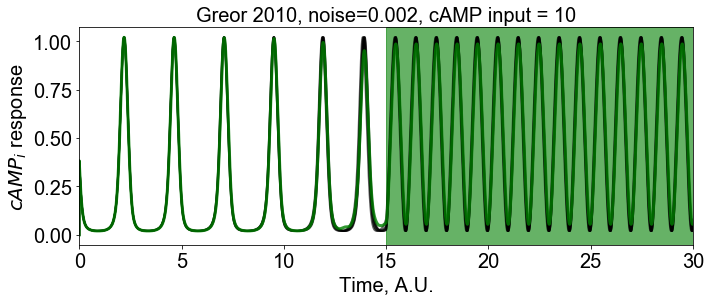

In [11]:
# specify which single cell traces to display
SC_traces_idx = [0,1,2,3,4,5]
title = 'Greor 2010, noise=' +str(eta)+', cAMP input = '+ str(cAMPext_influx)
# plot population mean and individual traces
plot_POP_oscillation(t_plot_Gregor,gregor_campCyto_trace_mean_norm, cAMPext_influx, 
                     t_tot, stim_time,title,gregor_campCyto_trace_norm, SC_traces_idx)

### 6. Sgro 2015 
#### Set up parameters

In [12]:
e=0.1 # excitability
tauA=0.09; tauR=tauA/e; g=0.5

rho = 10**(-3.5) # cell density
j = 0.5 # external flow rate

N = 100 # number of cells in the population
sigma = 0.15 # noise strength

SgroPopParam={'e':e,'tauA':tauA,'tauR':tauR,'g':g,'c0':1.2,'sigma':sigma,'N':N,\
            'a':0.058,'alpha0':800,'alpha_pde':1000,'Kd':1e-5,'S':1e6,\
            'offset_A':1.5,'flux_thrs':0, 'rho': rho,'j': j}

dt=0.001 ; t_tot=30; t=list(np.arange(0,t_tot*Nt_Sgro,dt))
nSteps = len(t)

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [13]:
# cAMPe influx level. By default low, itermediate and high levels are 10, 20 and 100
cAMPext_influx = 10 

stim_time= 0.5 # cAMPext_influx happens at half the total time
# allow for oscillation stablize for longer before cAMPe is applied
stim_time_step=int(round(stim_time*t_tot*Nt_Sgro/dt)) # at this time step input is applied
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx_trace[stim_time_step:] = cAMPext_influx
time_separation = 0

# initializations
A0=-1.5*np.ones(N) # + np.random.uniform(-sigma,sigma,N); ###########
R0=-0.5*np.ones(N) # + np.random.uniform(-sigma,sigma,N); 
cAMPext0 = 0
Sgro_pop=Sgro2015_pop(A0,R0,cAMPext0, SgroPopParam)

A_trace_orig=np.zeros((N,len(t)))
R_trace_orig=np.zeros((N,len(t)))
cAMPext_trace = np.zeros((len(t),1))
A_trace_orig[:,0]=A0 
R_trace_orig[:,0]=R0
cAMPext_trace[0] = cAMPext0

for i in range(nSteps-1):
    A_now=A_trace_orig[:,i]
    R_now=R_trace_orig[:,i]
    cAMPext_now = cAMPext_trace[i]
    A_next,R_next, cAMPext_next = Sgro_pop.update( dt, time_separation,cAMPext_influx_trace[i])
    A_trace_orig[:,i] = A_next
    R_trace_orig[:,i] = R_next
    cAMPext_trace[i] = cAMPext_next

# Rescale time
t_plot_Sgro = np.array(t)/(Nt_Sgro)
# Take cAMPi (A) population mean and normalize height
A_trace_norm =(A_trace_orig - Nh_Sgro_offset)/Nh_Sgro
A_trace_norm_mean = np.mean(A_trace_norm,axis=0)

#### Plot population $cAMP_i$  trace

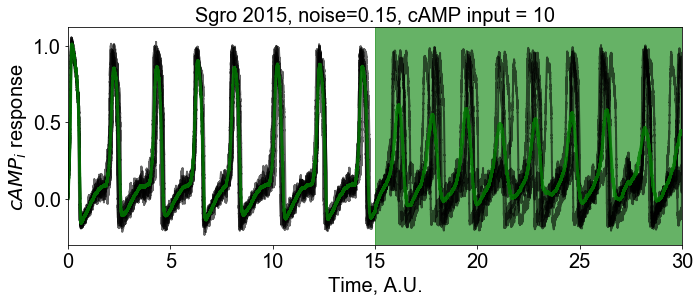

In [14]:
# specify which single cell traces to display
SC_traces_idx = [0,1,2,3,4,5]
title = 'Sgro 2015, noise=' +str(sigma)+', cAMP input = '+ str(cAMPext_influx)
# plot population mean and individual traces
plot_POP_oscillation(t_plot_Sgro,A_trace_norm_mean, cAMPext_influx, t_tot, stim_time,
                     title, A_trace_norm, SC_traces_idx)

### 7. Kamino 2017
#### Set up parameters

In [15]:
tau=1.5; n=2; K=4; kt=2; delta=0

gamma=3 # cAMPe dilution/degradation rate 
rho= 1 # population density

sigma = 0.01# noise strength
N=100 # number of cells in a population

KaminoPopParam={'tau':tau,'n':n,'K':K,'kt':kt,'delta':delta,
                'sigma':sigma, 'N':N,'rho':rho,'gamma':gamma}

dt=0.001; t_tot = 30; t=list(np.arange(0,t_tot*Nt_Kamino,dt))
nSteps = len(t)

#### Define $cAMP_{e}$ influx trace and get $cAMP_i$ simulation response

In [16]:
# cAMPe influx level. By default low, itermediate and high levels are 0.001,0.002 and 0.1
cAMPext_influx=0.002

stim_time= 0.5 # cAMPext_influx happens at half the total time
stim_time_step=int(round(stim_time*t_tot*Nt_Kamino/dt)) # at this time step input is applied
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx_trace[stim_time_step:] = cAMPext_influx

# Initializations
x0=0.01*np.ones(N)
y0=0.08*np.ones(N)
z0=0
x_trace=np.zeros((N,nSteps)); x_trace[:,0] = x0
y_trace=np.zeros((N,nSteps)); y_trace[:,0] = y0
z_trace=np.zeros((nSteps,1)); z_trace[0] = z0
Kamino_pop = Kamino2017_pop_SCnoise(x0,y0,z0,KaminoPopParam)

for i in range(nSteps-1):
    x_next,y_next,z_next=Kamino_pop.update(cAMPext_influx_trace[i],dt)
    x_trace[:,i+1] = x_next
    y_trace[:,i+1] = y_next
    z_trace[i+1] = z_next
    
# Rescale time
t_plot_Kamino = np.array(t)/(Nt_Kamino)
# Normalize height 
y_trace_norm =  (y_trace-Nh_Kamino_offset)/Nh_Kamino
y_trace_norm_mean = np.mean(y_trace_norm,axis=0)

#### Plot population $cAMP_i$  trace

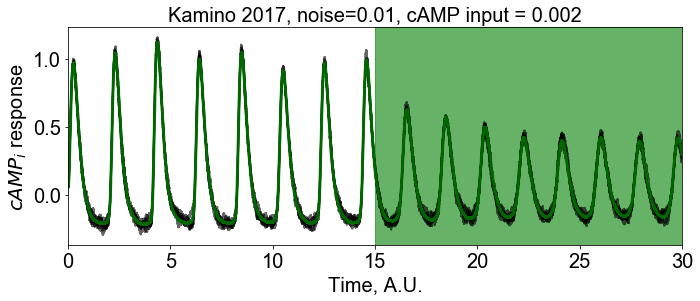

In [17]:
# specify which single cell traces to display
SC_traces_idx = [0,1,2,3,4,5]
title = 'Kamino 2017, noise=' +str(sigma)+', cAMP input = '+ str(cAMPext_influx)
# plot population mean and individual traces
plot_POP_oscillation(t_plot_Kamino,y_trace_norm_mean, cAMPext_influx, t_tot, stim_time,
                     title, y_trace_norm, SC_traces_idx)